## **Motivation**

  
이전 결과를 생각해보면 현재 데이터에서 이 모델을 써서 성능이 향상 시킬려면 overfitting문제를 해결해야한다.      
Object Detection기법 중 하나를 이용하고 이를 통해 객체를 탐지하고 나머지를 부분을 그림자처리하기(RSH)(인물사진 모드와 유사)를 통해 중요한 부분의 특징을 CNN이 더 잘 인식하게 하여 학습시킬 계획이다.  
이는 배경을 완전 배재한 것보다 testdata와 traindata의 괴리가 적을 것으로 예상된다.  
검은색에 RGD값은 0이고 convolution layer는 곱연산이기때문에 검은색에 가까울수록 중요도를 낮추는 효과가 어느정도 있다고 생각한다.    
코드 수정에 제한이 있어 object dectection을 따로 적용하는 모델을 만드는 것은 불가능하여 cifar data특성상 중앙에 중요 데이터가 있는 경우가 많아 중앙에 boundingbox를 지정하여 나머지 부분을 그림자처리하기로 한다.  

## **핵심아이디어, 구현 방법**

아래의 그림과 같이 중앙 부분을 밝기를 어둡게 처리하고 일정부분을 밝게 처리한다.

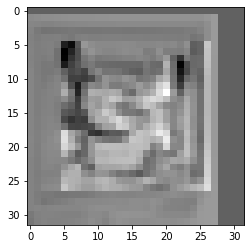

In [ ]:
for input,target in train_loader:
  x_test = input[0]
  break

plt.imshow(x_test[0,:,:],cmap="gray")

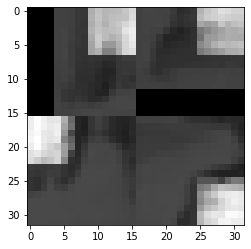

In [ ]:
#Cutshadow + local_augment (인용출처 부분에 논문 참조)
for input,target in train_loader:
  input,target = local_augment(input,target)
  x_test = input[0]
  break

plt.imshow(x_test[0,:,:],cmap="gray")

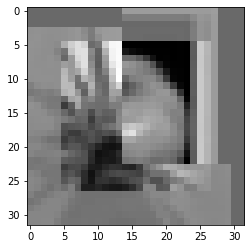

In [ ]:
#Cutshadow + Cutmix
for input,target in train_loader:
  input,target = cutmix(input, target, 0.01)
  x_test = input[0]
  break

plt.imshow(x_test[0,:,:],cmap="gray")

## **Import all neceassary packages**

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR

from torchvision import datasets, transforms

from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image, ImageChops
import torchvision.transforms.functional as TF

## **Model - Define ResNet Model**

In [ ]:
'''ResNet18/34/50/101/152 in Pytorch.'''

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)

def test_resnet():
    net = ResNet50()
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

# test_resnet()

## **Utils**

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## **data augmentation**

In [ ]:
class CutShadow(object):

    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):

        h = img.size(1)
        w = img.size(2)

        mask = np.zeros((h, w), np.float32)

        for n in range(self.n_holes):
            y = 16
            x = 16

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[:,:] = 1.
            mask[y1: y2, x1: x2] = 8. #밝기 차이를 나타내는 수

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        return img


In [ ]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2
    
def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.1,0.1)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)
    return new_data, targets

def local_augment(data,target):
  image= data.clone()

  h = image.size(2)
  w = image.size(3)
  for i in range(image.size(0)):
    mask1 = image[i,:,0:h//2,0:w//2]
    mask1[0] = torch.rot90(mask1[0]) 
    mask1[1] = torch.rot90(mask1[1]) 
    mask1[2] = torch.rot90(mask1[2]) 

    image[i,:,0:h//2,0:w//2] = mask1

    mask2 = image[i,:,0:h//2,w//2:w]
    mask2[0] = torch.rot90(mask2[0]) 
    mask2[1] = torch.rot90(mask2[1]) 
    mask2[2] = torch.rot90(mask2[2]) 
    mask2[0] = torch.rot90(mask2[0]) 
    mask2[1] = torch.rot90(mask2[1]) 
    mask2[2] = torch.rot90(mask2[2]) 
    image[i,:,0:h//2,w//2:w] = mask2

    mask3 = image[i,:,h//2:h,0:w//2]
    mask3[0] = torch.rot90(mask3[0]) 
    mask3[1] = torch.rot90(mask3[1]) 
    mask3[2] = torch.rot90(mask3[2]) 

    image[i,:,h//2:h,0:w//2] = mask3

    mask4 = image[i,:,h//2:h,w//2:w]
    mask4[0] = torch.rot90(mask4[0]) 
    mask4[1] = torch.rot90(mask4[1]) 
    mask4[2] = torch.rot90(mask4[2]) 
    mask4[0] = torch.rot90(mask4[0]) 
    mask4[1] = torch.rot90(mask4[1]) 
    mask4[2] = torch.rot90(mask4[2]) 
    image[i,:,h//2:h,w//2:w] = mask4

  return image,target

## **Parameter Settings**

In [ ]:
dataset = 'cifar100' # cifar10 or cifar100
model = 'resnet34' # resnet18, resnet50, resnet101
batch_size = 128  # Input batch size for training (default: 128)
epochs = 150 # Number of epochs to train (default: 200)
learning_rate = 0.1 # Learning rate
data_augmentation = True # Traditional data augmentation such as augmantation by flipping and cropping?
cutshadow = True 
n_holes = 1 # Number of holes to cut out from image
length = 14  # box크기(수정됨)
seed = 0 # Random seed (default: 0)
print_freq = 30
cuda = torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

test_id = dataset + '_' + model

## **Load and preprocess data**

In [ ]:
# Image Preprocessing
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])
if data_augmentation:
    train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
    train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)
if cutshadow:
    train_transform.transforms.append(CutShadow(n_holes=n_holes, length=length))



test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])

if dataset == 'cifar10':
    num_classes = 10
    train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)
elif dataset == 'cifar100':
    num_classes = 100
    train_dataset = datasets.CIFAR100(root='data/',
                                      train=True,
                                      transform=train_transform,
                                      download=True)

    test_dataset = datasets.CIFAR100(root='data/',
                                     train=False,
                                     transform=test_transform,
                                     download=True)


# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)


Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


## **Main Training**

## 세팅조건
가장 중요한 변수는 박스의 크기(length)와 밝기 차이(p)이다.

length = 12, p = 5 -> Top-1: 77.1 Top5: 93.92
length = 14, p = 2 -> Top-1: 74.85 Top5: 93.02 
length = 14, p = 5 -> Top-1: 76.78 Top5: 93.8  
length = 14, p = 8 -> Top-1: 77.39 Top5: 93.82   
length = 18, p = 2 -> Top-1: 71.96 Top5: 90.92  
length = 18, p = 3 -> Top-1: 69.49 Top5: 89.93   
length = 18, p = 5 -> Top-1: 72.67 Top5: 93.26  
length = 18, p = 8 -> Top-1: 74.66 Top5: 92.62  
length = 22, p = 5 -> Top-1: 56.38 Top5: 80.2  
length = 26, p = 5 -> Top-1: 35.86 Top5: 61.54  


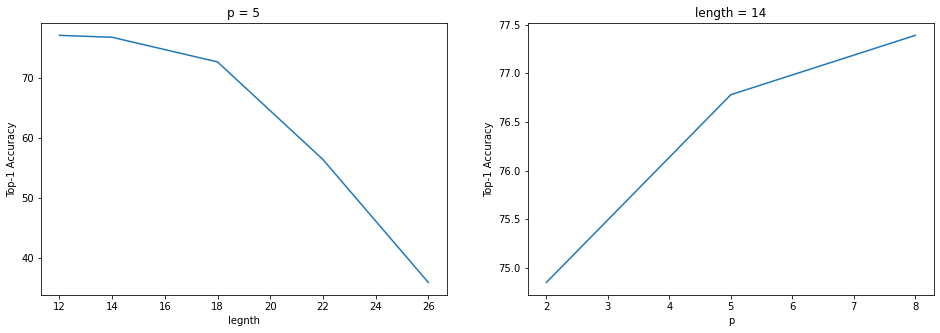

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1) 
plt.plot([12,14,18,22,26], [77.1,76.78,72.67,56.38,35.86])
plt.title("p = 5")
plt.xlabel('legnth')
plt.ylabel('Top-1 Accuracy')
plt.subplot(1, 2, 2)  
plt.plot([2,5,8], [74.85,76.78,77.39])
plt.title("length = 14")
plt.xlabel('p')
plt.ylabel('Top-1 Accuracy')
plt.show()

length가 작을수록 대체로 성능이 좋고 밝기 차이가 클수록 좋다. 하지만 이는 더 많은 학습을 진행을 못해 length가 더 작아지거나 밝기대비가 커질수록 더 성능이 안좋아 질 수도 있다.

In [ ]:
#크기 14 밝기 8
def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)

    print('==> Train Accuracy: Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

def test(test_loader,epoch, model):
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    model.eval()
    for i,(input,target) in enumerate(test_loader):
        input = input.cuda()
        target = target.cuda()

        output = model(input)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))
    print('==> Test Accuracy:  Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

model = ResNet34(num_classes=num_classes).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True, weight_decay=5e-4)

scheduler = MultiStepLR(optimizer, milestones=[60, 90, 120], gamma=0.2)

criterion = torch.nn.CrossEntropyLoss().cuda()
###########################################################
best_acc = 0
for epoch in range(epochs):
    print("\n----- epoch: {}, lr: {} -----".format(
        epoch, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train(train_loader, epoch, model, optimizer, criterion)
    test_acc = test(test_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'model_best.pt')

torch.save(model.state_dict(),'model_latest.pt')
print(f"Best Top-1 Accuracy: {best_acc}")


----- epoch: 0, lr: 0.1 -----
Epoch: [0][  0/391]	Time  0.307 ( 0.307)	Loss 4.7202e+00 (4.7202e+00)	Acc@1   0.78 (  0.78)	Acc@5   4.69 (  4.69)
Epoch: [0][ 30/391]	Time  0.170 ( 0.173)	Loss 4.5532e+00 (5.1999e+00)	Acc@1   3.12 (  1.36)	Acc@5  10.16 (  6.02)
Epoch: [0][ 60/391]	Time  0.173 ( 0.171)	Loss 4.5141e+00 (4.9110e+00)	Acc@1   2.34 (  1.36)	Acc@5  11.72 (  6.47)
Epoch: [0][ 90/391]	Time  0.172 ( 0.171)	Loss 4.3181e+00 (4.7582e+00)	Acc@1   2.34 (  1.79)	Acc@5  16.41 (  8.50)
Epoch: [0][120/391]	Time  0.173 ( 0.172)	Loss 4.1890e+00 (4.6416e+00)	Acc@1   4.69 (  2.28)	Acc@5  17.97 ( 10.43)
Epoch: [0][150/391]	Time  0.170 ( 0.171)	Loss 4.1694e+00 (4.5475e+00)	Acc@1   1.56 (  2.89)	Acc@5  23.44 ( 12.52)
Epoch: [0][180/391]	Time  0.170 ( 0.171)	Loss 4.1695e+00 (4.4728e+00)	Acc@1   3.91 (  3.36)	Acc@5  20.31 ( 14.00)
Epoch: [0][210/391]	Time  0.170 ( 0.171)	Loss 4.0378e+00 (4.4096e+00)	Acc@1   8.59 (  3.81)	Acc@5  25.00 ( 15.45)
Epoch: [0][240/391]	Time  0.168 ( 0.171)	Loss 4.0275e+00 

# 위 결과를 바탕으로 p = 8 ,length = 14로 다른 DA방식과 섞어봤다.


Cutshadow + Cutmix

In [ ]:
#Cutshadow + Cutmix(0.5)
def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        mix_decision = np.random.rand()
        if mix_decision < 0.5:
          input, targets = cutmix(input, target, 0.01)
        # measure data loading time
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)

        if mix_decision < 0.5:
          target_a = targets[0].cuda()
          target_b = targets[1].cuda()
          lam = targets[2]
          if lam>0.5:
            target = target_a
          else:
            target = target_b
          loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
        else:
          target = target.cuda()
          loss = loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)

    print('==> Train Accuracy: Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

def test(test_loader,epoch, model):
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    model.eval()
    for i,(input,target) in enumerate(test_loader):
        input = input.cuda()
        target = target.cuda()

        output = model(input)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))
    print('==> Test Accuracy:  Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

model = ResNet34(num_classes=num_classes).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True, weight_decay=5e-4)

scheduler = MultiStepLR(optimizer, milestones=[60, 90, 120], gamma=0.2)

criterion = torch.nn.CrossEntropyLoss().cuda()
###########################################################
best_acc = 0
for epoch in range(epochs):
    print("\n----- epoch: {}, lr: {} -----".format(
        epoch, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train(train_loader, epoch, model, optimizer, criterion)
    test_acc = test(test_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'model_best.pt')

torch.save(model.state_dict(),'model_latest.pt')
print(f"Best Top-1 Accuracy: {best_acc}")


----- epoch: 0, lr: 0.1 -----
Epoch: [0][  0/391]	Time  0.234 ( 0.234)	Loss 4.6667e+00 (4.6667e+00)	Acc@1   2.34 (  2.34)	Acc@5   6.25 (  6.25)
Epoch: [0][ 30/391]	Time  0.089 ( 0.096)	Loss 4.6106e+00 (5.2920e+00)	Acc@1   0.78 (  1.23)	Acc@5   5.47 (  5.27)
Epoch: [0][ 60/391]	Time  0.090 ( 0.093)	Loss 4.5598e+00 (4.9638e+00)	Acc@1   0.00 (  1.32)	Acc@5   5.47 (  6.02)
Epoch: [0][ 90/391]	Time  0.090 ( 0.092)	Loss 4.5285e+00 (4.8321e+00)	Acc@1   0.78 (  1.48)	Acc@5  13.28 (  6.87)
Epoch: [0][120/391]	Time  0.090 ( 0.092)	Loss 4.4977e+00 (4.7531e+00)	Acc@1   3.91 (  1.67)	Acc@5   4.69 (  7.41)
Epoch: [0][150/391]	Time  0.090 ( 0.091)	Loss 4.5319e+00 (4.6827e+00)	Acc@1   1.56 (  1.91)	Acc@5  14.84 (  8.63)
Epoch: [0][180/391]	Time  0.090 ( 0.091)	Loss 4.3106e+00 (4.6339e+00)	Acc@1   3.12 (  2.15)	Acc@5  13.28 (  9.56)
Epoch: [0][210/391]	Time  0.091 ( 0.091)	Loss 4.5935e+00 (4.5873e+00)	Acc@1   1.56 (  2.49)	Acc@5  14.84 ( 10.63)
Epoch: [0][240/391]	Time  0.090 ( 0.091)	Loss 4.4803e+00 

Cutshadow + local_augment

In [ ]:
#Cutshadow + local_augment
def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        input,target = local_augment(input,target)
        # measure data loading time
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)

    print('==> Train Accuracy: Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

def test(test_loader,epoch, model):
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    model.eval()
    for i,(input,target) in enumerate(test_loader):
        input = input.cuda()
        target = target.cuda()
        input,target = local_augment(input,target)
        output = model(input)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))
    print('==> Test Accuracy:  Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

model = ResNet34(num_classes=num_classes).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True, weight_decay=5e-4)

scheduler = MultiStepLR(optimizer, milestones=[60, 90, 120], gamma=0.2)

criterion = torch.nn.CrossEntropyLoss().cuda()
###########################################################
best_acc = 0
for epoch in range(epochs):
    print("\n----- epoch: {}, lr: {} -----".format(
        epoch, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train(train_loader, epoch, model, optimizer, criterion)
    test_acc = test(test_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'model_best.pt')

torch.save(model.state_dict(),'model_latest.pt')
print(f"Best Top-1 Accuracy: {best_acc}")


----- epoch: 0, lr: 0.1 -----
Epoch: [0][  0/391]	Time  0.378 ( 0.378)	Loss 4.7024e+00 (4.7024e+00)	Acc@1   0.78 (  0.78)	Acc@5   7.03 (  7.03)
Epoch: [0][ 30/391]	Time  0.099 ( 0.111)	Loss 4.9832e+00 (5.4467e+00)	Acc@1   2.34 (  1.01)	Acc@5   7.81 (  5.37)
Epoch: [0][ 60/391]	Time  0.101 ( 0.106)	Loss 4.4685e+00 (5.0371e+00)	Acc@1   3.12 (  1.36)	Acc@5  11.72 (  6.53)
Epoch: [0][ 90/391]	Time  0.100 ( 0.104)	Loss 4.4253e+00 (4.8509e+00)	Acc@1   1.56 (  1.76)	Acc@5  10.16 (  8.05)
Epoch: [0][120/391]	Time  0.101 ( 0.103)	Loss 4.4255e+00 (4.7347e+00)	Acc@1   3.12 (  2.16)	Acc@5  12.50 (  9.36)
Epoch: [0][150/391]	Time  0.109 ( 0.102)	Loss 4.2670e+00 (4.6568e+00)	Acc@1   7.03 (  2.45)	Acc@5  22.66 ( 10.33)
Epoch: [0][180/391]	Time  0.099 ( 0.102)	Loss 4.3208e+00 (4.5939e+00)	Acc@1   3.91 (  2.78)	Acc@5  19.53 ( 11.33)
Epoch: [0][210/391]	Time  0.099 ( 0.102)	Loss 4.1538e+00 (4.5417e+00)	Acc@1   4.69 (  3.01)	Acc@5  21.09 ( 12.24)
Epoch: [0][240/391]	Time  0.098 ( 0.101)	Loss 4.1489e+00 

### 분석 및 결론:  


(%)|Baseline(cutout) | CutShadow(CS)(length:14,p = 8)|Cutmix|Cutshadow + Cutmix| Cutshadow + local_augment|
---|---|---|---|---|---|
`Top-1 Accuracy` | 78.26 | 77.39 | 80.78 | 80.88 | 71.83 |
`Top-5 Accuracy` | 94.34 | 93.82 | 95.21 | 95.71 | 90.92 |

Bounding box의 크기가 작을수록 성능이 좋아지고,  
배경이 어두울수록 성능이 좋은 것으로 보아 기존에 학습이 traindata를 너무 학습해버려서  overfitting이 발생한것으로 볼 수 있다.  
이 방식이 ovefitting을 cutout방식보다 좋은 성능을 보여주는것 같지는 않았다. 
하지만 Cutmix와 혼합해서 사용했을때는 제법 괜찮은 효과를 보여주었다. 이 방법은 기존 데이터의 overfitting을 막아주고 상대적으로 적은 변형을 불러오기 때문에 다른 augmentation 방법과 혼용할때 성능이 잘 나와주는 것 같다.  


----------------------

### 인용(출처)  
https://github.com/uoguelph-mlrg/Cutout   
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9319662  
https://arxiv.org/abs/1905.04899  
https://arxiv.org/abs/2101.05361